# GPU Check

In [44]:
import os
import torch
import numpy as np
import math
import glob
from os import listdir
from os import walk
from torch import nn
from tqdm import tqdm 
from torch import optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import MultiStepLR, StepLR
from torchvision import datasets, transforms
from facenet_pytorch import InceptionResnetV1, fixed_image_standardization
import torchvision.models as models

import PIL.Image as Image
from matplotlib import pyplot as plt
import torch.nn.functional as F

In [45]:
data_path = '../../dataset/bird_datasets/train'
classes_path = '../../dataset/bird_datasets/classes.txt'
training_labels_path = '../../dataset/bird_datasets/training_labels.txt'

BATCH_SIZE = 8
WORKERS = 16
epochs = 100
learning_rate = 0.0001

pretrain = 'model/model_bird_vic_res50_addBN'

output_foloder = 'model/model_bird_SSL_VIC'

print('torch version:' + torch.__version__)

if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Available GPUs: ', end='')
    for i in range(torch.cuda.device_count()):
        print(torch.cuda.get_device_name(i), end=' ')
else:
    device = torch.device('cpu')
    print('CUDA is not available.')

torch version:1.8.0
Available GPUs: GeForce RTX 2080 Ti GeForce GTX 1080 Ti 

# Dataset

#### Define dataset, and dataloader

In [46]:
IMG_EXTENSIONS = [
    '.jpg', '.JPG', '.jpeg', '.JPEG',
    '.png', '.PNG', '.ppm', '.PPM', '.bmp', '.BMP',
]

def is_image_file(filename):
    return any(filename.endswith(extension) for extension in IMG_EXTENSIONS)

def make_dataset(dir, data_list):
    images = []
    for img_name, idx, labels in data_list:
        item = (img_name, int(idx))
        images.append(item)
    return images

class BirdImageLoader(Dataset):
    def __init__(self, root, data_list, class_to_idx, transform=None, target_transform=None):
        imgs = make_dataset(root, data_list)

        self.root = root
        self.imgs = imgs
        self.class_to_idx = class_to_idx
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        path, target = self.imgs[index]
        img = Image.open(os.path.join(self.root, path)).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, target

    def __len__(self):
        return len(self.imgs)

# Data augmentation

In [47]:
from PIL import ImageFilter
import random

class GaussianBlur(object):
    def __init__(self, sigma=[.1, 2.]):
        self.sigma = sigma

    def __call__(self, x):
        sigma = random.uniform(self.sigma[0], self.sigma[1])
        x = x.filter(ImageFilter.GaussianBlur(radius=sigma))
        return x
    
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# https://github.com/aniket03/self_supervised_bird_classification/blob/master/dataset_helpers.py
def all_in_aug():
    all_in_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=[0.5, 1.5]),
    transforms.RandomRotation(degrees=15),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])
    return all_in_transform

def get_aug_trnsform():
    transform = transforms.Compose([
        transforms.RandomResizedCrop(300, scale=(0.2, 1.)),
        transforms.RandomApply([
            transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)  # not strengthened
        ], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        transforms.RandomApply([GaussianBlur([.1, 2.])], p=0.5),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ])
    return transform

def get_trnsform():
    transform = transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(1., 1.)),
        transforms.ToTensor(),
        normalize
    ])
    return transform
trans_aug = all_in_aug()
trans = get_trnsform()

## read classes txt

In [48]:
class_to_idx = {}
with open(classes_path) as f:
    for line in f.readlines():
        label_num =  line.split(".")[0] 
        label_str =  line.split(".")[1][:-1]
        class_to_idx[int(label_num) - 1] = label_str
print(class_to_idx)

{0: 'Black_footed_Albatross', 1: 'Laysan_Albatross', 2: 'Sooty_Albatross', 3: 'Groove_billed_Ani', 4: 'Crested_Auklet', 5: 'Least_Auklet', 6: 'Parakeet_Auklet', 7: 'Rhinoceros_Auklet', 8: 'Brewer_Blackbird', 9: 'Red_winged_Blackbird', 10: 'Rusty_Blackbird', 11: 'Yellow_headed_Blackbird', 12: 'Bobolink', 13: 'Indigo_Bunting', 14: 'Lazuli_Bunting', 15: 'Painted_Bunting', 16: 'Cardinal', 17: 'Spotted_Catbird', 18: 'Gray_Catbird', 19: 'Yellow_breasted_Chat', 20: 'Eastern_Towhee', 21: 'Chuck_will_Widow', 22: 'Brandt_Cormorant', 23: 'Red_faced_Cormorant', 24: 'Pelagic_Cormorant', 25: 'Bronzed_Cowbird', 26: 'Shiny_Cowbird', 27: 'Brown_Creeper', 28: 'American_Crow', 29: 'Fish_Crow', 30: 'Black_billed_Cuckoo', 31: 'Mangrove_Cuckoo', 32: 'Yellow_billed_Cuckoo', 33: 'Gray_crowned_Rosy_Finch', 34: 'Purple_Finch', 35: 'Northern_Flicker', 36: 'Acadian_Flycatcher', 37: 'Great_Crested_Flycatcher', 38: 'Least_Flycatcher', 39: 'Olive_sided_Flycatcher', 40: 'Scissor_tailed_Flycatcher', 41: 'Vermilion_Fly

## read labels txt

In [49]:
data_list = []
with open(training_labels_path) as f:
    for line in f.readlines():
        file_name =  line.split(" ")[0]
        label_num =  int(line.split(" ")[1].split(".")[0]) -1
        label_str =  line.split(" ")[1].split(".")[1][:-1]
        data_list.append([file_name, label_num, label_str])

train_data_list = data_list[:int(len(data_list) * 0.8)]
val_data_list = data_list[int(len(data_list) * 0.8):int(len(data_list) * 0.9)]
test_data_list = data_list[int(len(data_list) * 0.9):]

print("all data : ", len(data_list))
print("train data : ", len(train_data_list))
print("val data : ", len(val_data_list))
print("test data : ", len(test_data_list))
print(train_data_list[:10])

all data :  3000
train data :  2400
val data :  300
test data :  300
[['4283.jpg', 114, 'Brewer_Sparrow'], ['3982.jpg', 161, 'Canada_Warbler'], ['5836.jpg', 143, 'Common_Tern'], ['5980.jpg', 7, 'Rhinoceros_Auklet'], ['4168.jpg', 160, 'Blue_winged_Warbler'], ['2352.jpg', 60, 'Heermann_Gull'], ['0511.jpg', 37, 'Great_Crested_Flycatcher'], ['4492.jpg', 146, 'Least_Tern'], ['1254.jpg', 131, 'White_crowned_Sparrow'], ['2792.jpg', 176, 'Prothonotary_Warbler']]


In [50]:
dataset_train = BirdImageLoader(data_path, train_data_list, class_to_idx, transform=trans_aug)
dataset_val = BirdImageLoader(data_path, val_data_list, class_to_idx, transform=trans)
dataset_test = BirdImageLoader(data_path, test_data_list, class_to_idx, transform=trans)

train_loader = DataLoader(
    dataset_train,
    num_workers=WORKERS,
    batch_size=BATCH_SIZE,
    shuffle=True
)
val_loader = DataLoader(
    dataset_val,
    num_workers=WORKERS,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_loader = DataLoader(
    dataset_test,
    num_workers=WORKERS,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print('class_to_idx ', len(dataset_train.class_to_idx))
print('val_loader ', len(dataset_train.class_to_idx))
dataset_train.__len__()


class_to_idx  200
val_loader  200


2400

### Test Data loader

0it [00:00, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


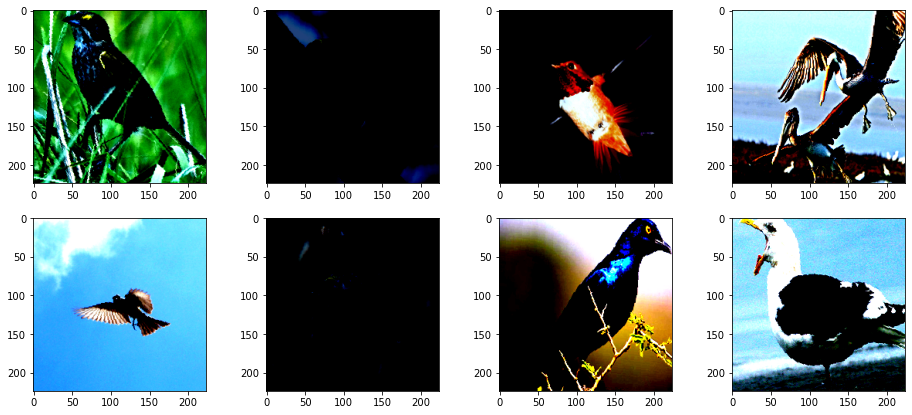

0it [00:01, ?it/s]

tensor([127,  95,  68,  99,  76, 170, 133,  64])
torch.Size([8])


In [51]:
dataset_debug = BirdImageLoader(data_path, train_data_list, class_to_idx, transform=trans_aug)
debug_loader = DataLoader(
    dataset_debug,
    num_workers=WORKERS,
    batch_size=BATCH_SIZE,
    shuffle=True
)

for i_batch, image_batch in tqdm(enumerate(debug_loader)):
    x, y = image_batch[0], image_batch[1]
    ROW, COL = 2, 4
    f, ax = plt.subplots(ROW, COL, figsize=(16, 7))
    for i in range(ROW):
        for j in range(COL):
            img = x[i*COL+j]
            ax[i][j].imshow(img.permute(1, 2, 0))
    plt.show()
    break
print(y)
print(y.size())

# model

 ### define optimizer, scheduler

In [52]:
# make embedding to length=1
class L2_norm(nn.Module):
    def __init__(self):
        super(L2_norm, self).__init__()

    def forward(self, x):
        return F.normalize(x, p=2, dim=-1)

### fix model

In [53]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [62]:
# model = models.resnet50(pretrained=True).to(device)
encoder = torch.load('{}/checkpoint_encoder.pth.tar'.format(pretrain)).to(device)

projector = nn.Sequential(
    nn.Linear(1000, 1024),nn.BatchNorm1d(1024), nn.ReLU(),
    nn.Linear(1024, 1024),nn.BatchNorm1d(1024), nn.ReLU(),
    nn.Linear(1024, 200)
).to(device)

model = nn.Sequential(encoder, projector).to(device)
model_optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# weight_decay_val = 1e-4
# model_optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum = 0.9, weight_decay = weight_decay_val)

model_scheduler = StepLR(model_optimizer, 5)

#### Define loss and evaluation functions

In [63]:
crossEntropyLoss_fn = torch.nn.CrossEntropyLoss()
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

#### Train model

In [64]:
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')

In [65]:
def update_loss_hist(train_list, val_list, name='result'):
    clear_output(wait=True)
    plt.plot(train_list)
    plt.plot(val_list)
    plt.title(name)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='center right')
    plt.savefig('{}/{}.png'.format(output_foloder, name))
    plt.show()

In [66]:
def pass_epoch(loader, mode = 'Train'):
    loss = 0
    loss_acc_top1 = 0
    loss_acc_top5 = 0
    
    for i_batch, image_batch in tqdm(enumerate(loader)):
        x, y = image_batch[0].to(device), image_batch[1].to(device)
        if mode == 'Train':
            model.train()
        elif mode == 'Eval':
            model.eval()
        else:
            print('error model mode!')
        y_pred = model(x)

        loss_batch = crossEntropyLoss_fn(y_pred, y)
        loss_batch_acc_top = accuracy(y_pred, y, topk=(1, 5))

        if mode == 'Train':
            model_optimizer.zero_grad()
            loss_batch.backward()
            model_optimizer.step()
        
        loss += loss_batch.detach().cpu()
        loss_acc_top1 += loss_batch_acc_top[0]
        loss_acc_top5 += loss_batch_acc_top[1]
        
    loss /= (i_batch + 1)
    loss_acc_top1 /= (i_batch + 1)
    loss_acc_top5 /= (i_batch + 1)
    
    return loss, loss_acc_top1, loss_acc_top5

In [67]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

train_loss_history = []
train_acc_top1_history = []
train_acc_top5_history = []


val_loss_history = []
val_acc_top1_history = []
val_acc_top5_history = []

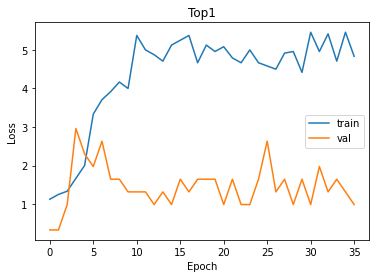


Epoch 37/100
----------


84it [00:06, 12.82it/s]


KeyboardInterrupt: 

In [68]:
for epoch in range(epochs):
    print('\nEpoch {}/{}'.format(epoch + 1, epochs))
    print('-' * 10)
    train_loss, train_acc_top1, train_acc_top5 = pass_epoch(train_loader, 'Train')  
    with torch.no_grad():
        val_loss, val_acc_top1, val_acc_top5 = pass_epoch(val_loader, 'Eval') 
    
    train_loss_history.append(train_loss)
    train_acc_top1_history.append(train_acc_top1)
    train_acc_top5_history.append(train_acc_top5)


    val_loss_history.append(val_loss)
    val_acc_top1_history.append(val_acc_top1)
    val_acc_top5_history.append(val_acc_top5)
    
    update_loss_hist(train_loss_history, val_loss_history, 'Loss')
    update_loss_hist(train_acc_top5_history, val_acc_top5_history, 'Top5')
    update_loss_hist(train_acc_top1_history, val_acc_top1_history, 'Top1')
    model_scheduler.step()
    save_checkpoint({
        'epoch': epoch + 1,
        'arch': 'Resnet50',
        'learning_rate': learning_rate,
        'loss': 'CrossEntropyLoss',
        'state_dict': model.state_dict(),
    }, is_best=False, filename='{}/checkpoint_{:04d}.pth.tar'.format(output_foloder, epoch + 1))
torch.save(model, '{}/checkpoint.pth.tar'.format(output_foloder))
torch.cuda.empty_cache()